In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import os
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')

<h2>Data Loading and Selection</h2>

The aim of this part is create the following variables:
1. Market Capitalization
2. Price
3. Rank: the rank of the cryptocurrency based on market capitalization
4. Market Share: ratio of market capitalization of the cryptocurrency and the total market capitalization over the entire cryptocurrency universe
5. Volume
6. Age: the number of days since the first time the cryptocurrency trades on the market
7. ROI: return on investment which is return of investment relative to cost of investment. Formula is shown below.

\begin{equation*}
ROI_{c, t} = \frac{P_{c, t} - P_{c, t-1}}{P_{c, t-1}}
\end{equation*}



Furthermore, I will limiting the universe of the cryptocurrency to currencies with average market cap of bigger than US$1,000,000 and with average daily volume of 10,000 during the training period.

In [2]:
DATA_DIR = './data'
DATA_FILE = 'crypto-historical-data.csv'

In [3]:
VAL_START = pd.Timestamp('2016-04-25')
TEST_START = pd.Timestamp('2017-04-25')

TRAIN_START = pd.Timestamp('2016-04-28')
TRAIN_END = pd.Timestamp('2017-04-24')

In [4]:
def load_data(file_location):
    data = pd.read_csv((file_location), 
                   parse_dates=['time'], 
                   index_col=0, 
                   keep_default_na=False,
                   header=0,
                   names=['market_cap', 'name', 'price', 'sym', 'time', 'volume'])

    data.sort_values(by=['sym', 'time'], inplace=True)
    data.reset_index(drop=True, inplace=True)
    return data

In [5]:
def process_data(data):
    data['rank'] = data.groupby("time")["market_cap"] \
                    .rank("dense", ascending=False) \
                    .astype(int)

    data['market_share'] = data.groupby('time')["market_cap"] \
                        .apply(lambda x: x/float(x.sum()))

    data['age'] = data.groupby(['sym'])["time"] \
                        .apply(lambda x: x - min(x)) \
                        .dt.days + 1

    previous_price = data.groupby(['sym'])['price'].shift(-1)
    data['roi'] = data['price']/previous_price - 1
    return data

In [6]:
def filter_data(data):
    window = data.query('time < @VAL_START')
    
    mean = window.groupby('sym').mean()
    symbols = mean.query("market_cap > 1000000 & volume > 10000") \
                        .index.unique()
    
    filtered = data.query('sym in @symbols')
    
    return filtered

In [7]:
raw = load_data(os.path.join(DATA_DIR, DATA_FILE))
processed = process_data(raw)
data = filter_data(processed)

In [8]:
data

,market_cap,name,price,sym,time,volume,rank,market_share,age,roi
27998,944816.0,Synereo,0.003485,AMP,2015-12-16,4.0,33,0.000124,1,-0.210646
27999,643767.0,Synereo,0.004415,AMP,2015-12-17,20.0,48,0.000087,2,0.259629
28000,815448.0,Synereo,0.003505,AMP,2015-12-18,34.0,38,0.000110,3,-0.110180
28001,647622.0,Synereo,0.003939,AMP,2015-12-19,222.0,50,0.000086,4,-0.063481
28002,727785.0,Synereo,0.004206,AMP,2015-12-20,13.0,40,0.000097,5,0.011787
...,...,...,...,...,...,...,...,...,...,...
670820,1087180.0,Zetacoin,0.006791,ZET,2018-04-08,2454.0,765,0.000004,1671,0.209224
670821,1141790.0,Zetacoin,0.005616,ZET,2018-04-09,1067.0,756,0.000004,1672,-0.010048
670822,943582.0,Zetacoin,0.005673,ZET,2018-04-10,9888.0,780,0.000004,1673,0.072198
670823,953339.0,Zetacoin,0.005291,ZET,2018-04-11,6207.0,779,0.000004,1674,-0.129340


<h2>Features</h2>

In the previous notebook, we created the variables to define the characteristic of a certain coin. In this notebook, we will take a step further in processing these variables to create the following features for training:
1. Mean
2. Median
3. Standard Deviation
4. Last Value
5. Overall trend (Difference between first and last value)

These features will be calculated for each variable we created previously and will be built based on a trailing window of width $w$ for a certain coin. $w$ is measured in days. To illustrate this, take a look at an example below.

In [9]:
data.query("sym == 'BTC'").head(10)

,market_cap,name,price,sym,time,volume,rank,market_share,age,roi
96942,1.500520e+09,Bitcoin,134.21,BTC,2013-04-28,0.0,1,0.943614,1,-0.071468
96943,1.491160e+09,Bitcoin,144.54,BTC,2013-04-29,0.0,1,0.942565,2,0.039856
96944,1.597780e+09,Bitcoin,139.00,BTC,2013-04-30,0.0,1,0.944742,3,0.188136
96945,1.542820e+09,Bitcoin,116.99,BTC,2013-05-01,0.0,1,0.943926,4,0.111967
96946,1.292190e+09,Bitcoin,105.21,BTC,2013-05-02,0.0,1,0.941565,5,0.076317
96947,1.180070e+09,Bitcoin,97.75,BTC,2013-05-03,0.0,1,0.939769,6,-0.131111
96948,1.089890e+09,Bitcoin,112.50,BTC,2013-05-04,0.0,1,0.939858,7,-0.029419
96949,1.254760e+09,Bitcoin,115.91,BTC,2013-05-05,0.0,1,0.940355,8,0.032146
96950,1.289470e+09,Bitcoin,112.30,BTC,2013-05-06,0.0,1,0.941318,9,0.007175
96951,1.248470e+09,Bitcoin,111.50,BTC,2013-05-07,0.0,1,0.944441,10,-0.018227


The data above shows the last 11 data points in the BTC timeline. Assume that we are trying to predict for its price on 2018-04-12 (which we can annotate as $t$) and that we have decided to $w$ be 10. This means, to calculate the features to predict for this time step $t$, we will use the previous 10 data points preceding $t$. In this case, the average price will be the average of prices between 2018-04-02 ($t-10$) and 2018-04-11 ($t-1$), inclusive. 

In [10]:
mean_price = data.query("sym == 'BTC'")['price'][1:10].mean()
print(mean_price)

117.29999999999998


Therefore, the general equation to calculate mean for a given $w$ is as follows:

$$mean = \frac{1}{w}{\textstyle\sum}_{n=1}^{w}{V_{t-n}}$$
<div style="text-align: center">Where $V$ can be any coin related variables we defined previously such as market capitalization, volume, rank, etc. </div></br>


Similarly median, standard deviation, last value and overall trend are calculated in a similar manner in terms of the data points being used even though the equation to process them are different.

<h2>Feature Engineering</h2>

This part is meant to develop the function to calculate the features for a given $w$.

In [11]:
PROPERTIES = ['market_cap', 'price', 'volume', 'rank', 'market_share', 'age', 'roi']

In [12]:
def create_features(data, W):
    features = []

    for p in PROPERTIES:
        first = data.groupby(['sym'])[p].shift(W)

        data[p + '_mean'] = data.groupby(['sym'])[p].shift(1) \
                                    .transform(lambda x: x.rolling(W, min_periods=1).mean())
        data[p + '_median'] = data.groupby(['sym'])[p].shift(1) \
                                    .transform(lambda x: x.rolling(W, min_periods=1).median())
        data[p + '_std'] = data.groupby(['sym'])[p].shift(1) \
                                    .transform(lambda x: x.rolling(W, min_periods=1).std(ddof=0))
        data[p + '_last'] = data.groupby(['sym'])[p].shift(1)
        data[p + '_delta'] = data[p + '_last'] - first
        
        features = features + [p + '_mean', p + '_median', p + '_std', p + '_last', p + '_delta']
        
    data.dropna(inplace=True)
    
    return {'data': data, 'features': features}

In [13]:
features_dict = create_features(data, W=7)
features = features_dict['features']
features_df = features_dict['data']

In [14]:
features_df.query("sym == 'BTC'").head()

,market_cap,name,price,sym,time,volume,rank,market_share,age,roi,...,age_mean,age_median,age_std,age_last,age_delta,roi_mean,roi_median,roi_std,roi_last,roi_delta
96949,1.254760e+09,Bitcoin,115.91,BTC,2013-05-05,0.0,1,0.940355,8,0.032146,...,4.0,4.0,2.0,7.0,6.0,0.026325,0.039856,0.102579,-0.029419,0.042049
96950,1.289470e+09,Bitcoin,112.30,BTC,2013-05-06,0.0,1,0.941318,9,0.007175,...,5.0,5.0,2.0,8.0,6.0,0.041127,0.039856,0.094562,0.032146,-0.007710
96951,1.248470e+09,Bitcoin,111.50,BTC,2013-05-07,0.0,1,0.944441,10,-0.018227,...,6.0,6.0,2.0,9.0,6.0,0.036459,0.032146,0.095313,0.007175,-0.180961
96952,1.219450e+09,Bitcoin,113.57,BTC,2013-05-08,0.0,1,0.944335,11,0.007988,...,7.0,7.0,2.0,10.0,6.0,0.006978,0.007175,0.073185,-0.018227,-0.130193
96953,1.259980e+09,Bitcoin,112.67,BTC,2013-05-09,0.0,1,0.943585,12,-0.038652,...,8.0,8.0,2.0,11.0,6.0,-0.007876,0.007175,0.059674,0.007988,-0.068329


<h2>Feature Visualization</h2>

In this section, we will take a look at the relationship of the features to the target label or the target price to see if we can spot certain trends. 

In [64]:
def plotting(df_container, var, title, scale='linear'):
    plt.figure(figsize=(6,5))

    for sym in df_container:
        df_container[sym][var].plot(label=sym, lw=1)
    plt.title(title)
    plt.legend()
    plt.yscale(scale)
    plt.savefig(os.path.join('./plots', var + '.png'), dpi=200, bbox_inches='tight')
    plt.show()

In [65]:
# Identify the top 10 coin based on market cap as of the latest date, April 24, 2018
latest_data = features_df[features_df['time'] == max(features_df['time'])]
latest_top_10 = latest_data.nlargest(10, 'market_cap_last')['sym'].values

# Filter processed data to include only the top 10 symbols
all_data_top_10 = features_df[features_df['sym'].isin(latest_top_10)]

# Create separate dataframe for each symbol
df_container = {}

for sym in latest_top_10:
    sym_df = features_df[features_df['sym'] == sym]
    sym_df['time'] = pd.to_datetime(sym_df['time'])
    sym_df.index = sym_df['time']
    df_container[sym] = sym_df

In [66]:
features_df[features_df['sym'] == 'BTC'][[x for x in features_df.columns if 'price' in x or 'roi' in x]].iloc[:20,:]

,price,roi,price_mean,price_median,price_std,price_last,price_delta,roi_mean,roi_median,roi_std,roi_last,roi_delta
96970,133.48,0.028748,126.091429,123.89,4.380125,131.98,9.99,-0.012624,-0.008152,0.017267,-0.011238,-0.011156
96971,129.75,0.005814,127.732857,126.70,4.678335,133.48,11.48,-0.008505,-0.008152,0.022433,0.028748,0.035909
96972,129.00,-0.024943,128.840000,129.75,4.067828,129.75,6.87,-0.006652,-0.008152,0.022997,0.005814,0.013966
96973,132.30,0.027174,129.714286,129.75,3.272919,129.00,5.11,-0.009050,-0.011238,0.023887,-0.024943,-0.002765
96974,128.80,-0.001550,130.915714,131.98,2.318977,132.30,5.60,-0.002000,0.005814,0.026148,0.027174,0.075973
96975,129.00,-0.002320,131.215714,131.98,1.840713,128.80,-4.40,0.004750,0.005814,0.018036,-0.001550,-0.010794
96976,129.30,0.057323,130.615714,129.75,1.779630,129.00,-2.98,0.003098,-0.001550,0.018078,-0.002320,0.008917
96977,122.29,0.000573,130.232857,129.30,1.732601,129.30,-4.18,0.012892,0.005814,0.024932,0.057323,0.028575
96978,122.22,0.006589,128.634286,129.00,2.820090,122.29,-7.46,0.008867,0.000573,0.024314,0.000573,-0.005241
96979,121.42,-0.001891,127.558571,129.00,3.534897,122.22,-6.78,0.008978,0.000573,0.024301,0.006589,0.031532


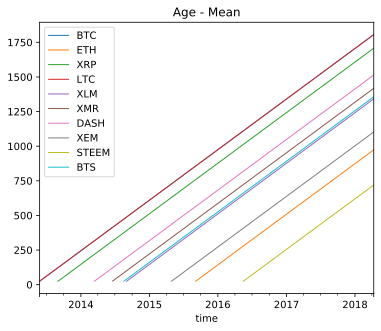

In [67]:
plotting(df_container, 'age_mean', 'Age - Mean')

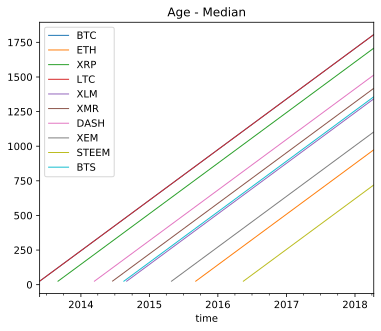

In [68]:
plotting(df_container, 'age_median', 'Age - Median')

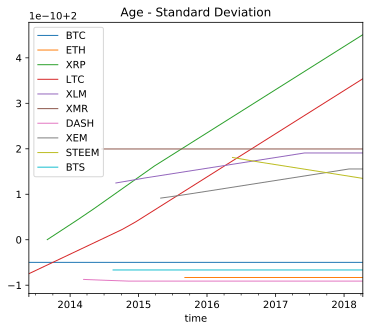

In [69]:
plotting(df_container, 'age_std', 'Age - Standard Deviation')

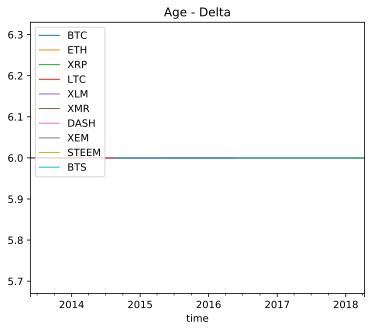

In [70]:
plotting(df_container, 'age_delta', 'Age - Delta')

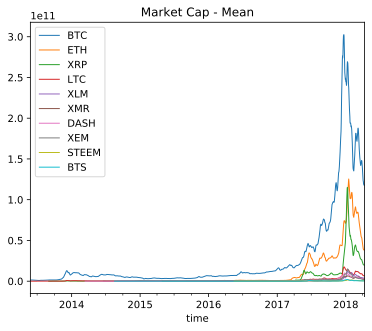

In [71]:
plotting(df_container, 'market_cap_mean', 'Market Cap - Mean')

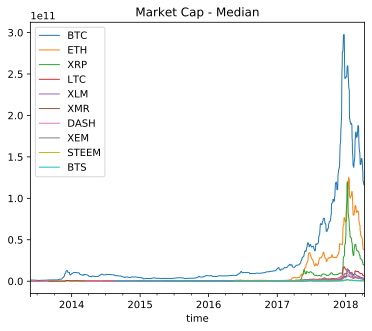

In [72]:
plotting(df_container, 'market_cap_median', 'Market Cap - Median')

We can see that some features related to age seem to be constant accross the given time period. They should be remove as they would not provide any predictive value to the model. Features to be removed:
1. age_mean
2. age_median
3. age_stdev
4. age_delta


In [24]:
features.remove('age_mean')
features.remove('age_median')
features.remove('age_std')
features.remove('age_delta')

In [25]:
features

['market_cap_mean',
 'market_cap_median',
 'market_cap_std',
 'market_cap_last',
 'market_cap_delta',
 'price_mean',
 'price_median',
 'price_std',
 'price_last',
 'price_delta',
 'volume_mean',
 'volume_median',
 'volume_std',
 'volume_last',
 'volume_delta',
 'rank_mean',
 'rank_median',
 'rank_std',
 'rank_last',
 'rank_delta',
 'market_share_mean',
 'market_share_median',
 'market_share_std',
 'market_share_last',
 'market_share_delta',
 'age_last',
 'roi_mean',
 'roi_median',
 'roi_std',
 'roi_last',
 'roi_delta']

<h2> Data Split </h2>

Before moving on to modelling, let us define the training and test set. In this project, we will be trading from April 25, 2017 onwards. Therefore, training set will include all data *before* this cutoff date, while test set will include all data *after* this cutoff date.

Unfortunate, since our features set is generated based on the value of $w$ we choose, we cannot separate the the training and test set using the raw data. Therefore, we will create a function to do this. 

In [26]:
VAL_START = pd.Timestamp('2016-04-25')
TEST_START = pd.Timestamp('2017-04-25')

TRAIN_START = pd.Timestamp('2016-04-28')
TRAIN_END = pd.Timestamp('2017-04-24')

In [27]:
def create_sets(df, features, target):
    criteria = {'train': "time < @VAL_START", 
                'val': "time >= @VAL_START & time < @TEST_START",
                'trainval': "time <= @TEST_START", 
                'test': "time >= @TEST_START"}

    sets = {}
    sets['features'] = features

    for key in criteria:
        sets[key] = {}
        sets[key]['full'] = df.query(criteria[key])
        sets[key]['X'] = sets[key]['full'][features]
        sets[key]['Y'] = sets[key]['full'][target]
        
    return sets

In [28]:
sets = create_sets(features_df, features, 'price')

In [29]:
sets['test']['full'].head()

,market_cap,name,price,sym,time,volume,rank,market_share,age,roi,...,age_mean,age_median,age_std,age_last,age_delta,roi_mean,roi_median,roi_std,roi_last,roi_delta
28491,8014400.0,Synereo,0.096706,AMP,2017-04-25,125241.0,60,0.000263,497,-0.032785,...,493.0,493.0,2.0,496.0,6.0,0.021311,0.021568,0.031380,0.007269,-0.017639
28492,7957810.0,Synereo,0.099984,AMP,2017-04-26,125740.0,63,0.000258,498,-0.115616,...,494.0,494.0,2.0,497.0,6.0,0.013069,0.021497,0.036510,-0.032785,-0.100169
28493,8229500.0,Synereo,0.113055,AMP,2017-04-27,355183.0,62,0.000261,499,0.034819,...,495.0,495.0,2.0,498.0,6.0,-0.013074,0.007269,0.050929,-0.115616,-0.074677
28494,9244050.0,Synereo,0.109251,AMP,2017-04-28,211446.0,59,0.000278,500,-0.079464,...,496.0,496.0,2.0,499.0,6.0,-0.002252,0.021497,0.051898,0.034819,0.013251
28495,8995880.0,Synereo,0.118682,AMP,2017-04-29,205368.0,61,0.000260,501,0.028520,...,497.0,497.0,2.0,500.0,6.0,-0.016685,0.007269,0.057059,-0.079464,-0.126950


<h2> XGBoost </h2>

In [30]:
import os
import ast
import json
import numpy as np
import pandas as pd
import source

import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
import sklearn.model_selection

import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.estimator import Estimator
from sagemaker.sklearn.estimator import SKLearn
from sklearn.preprocessing import MinMaxScaler

session = sagemaker.Session()
role = get_execution_role()

In [31]:
W = 7
target = 'price'

features_dict = create_features(data, W)
features = features_dict['features']
features_df = features_dict['data']
sets = create_sets(data, features, target)

In [32]:
prefix = 'xgboost'

pd.concat([sets['train']['Y'], sets['train']['X']], axis=1).to_csv(os.path.join(DATA_DIR, 'train.csv'), header=False, index=False)
pd.concat([sets['val']['Y'], sets['val']['X']], axis=1).to_csv(os.path.join(DATA_DIR, 'val.csv'), header=False, index=False)

train_location = session.upload_data(os.path.join(DATA_DIR, 'train.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(DATA_DIR, 'val.csv'), key_prefix=prefix)

s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [33]:
hyperparams = {
        "max_depth": "10",
        "eta": "0.2",
        "gamma": "0",
        "min_child_weight": "1",
        "subsample": "0.8",
        "objective": "reg:squarederror",
        "num_round": "100",
        "verbosity": "0",
        "early_stopping_rounds": "10",
        "disable": '1'
}

In [34]:
script_path = './source/mape.py'

xgb_custom = XGBoost(entry_point=script_path,
                    framework_version='1.0-1',
                    hyperparameters=hyperparams,
                    role=role,
                    train_instance_count=1,
                    train_instance_type='ml.m4.xlarge',
                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix))

xgb_custom.fit({'train': s3_input_train, 'validation': s3_input_validation})

2021-02-06 19:30:49 Starting - Starting the training job...
2021-02-06 19:30:51 Starting - Launching requested ML instances......
2021-02-06 19:31:54 Starting - Preparing the instances for training......
2021-02-06 19:33:08 Downloading - Downloading input data
2021-02-06 19:33:08 Training - Downloading the training image...
2021-02-06 19:33:46 Training - Training image download completed. Training in progress...INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Invoking user training script.
INFO:sagemaker-containers:Module mape does not provide a setup.py. 
Generating setup.py
INFO:sagemaker-containers:Generating setup.cfg
INFO:sagemaker-containers:Generating MANIFEST.in
INFO:sagemaker-containers:Installing module with the following command:
/miniconda3/bin/python -m pip install . 
Processing /opt/ml/code
  Created wheel for mape: filename=m

In [35]:
predictor = xgb_custom.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
predictor.content_type = 'text/csv'
predictor.serializer = csv_serializer

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!

In [36]:
pred_Y = [predictor.predict(batch) for batch in np.array_split(sets['test']['X'].values, 100)]
pred_Y = np.array([float(val[0]) for sublist in pred_Y for val in sublist])

test_result = sets['test']['full'].copy()
test_result['pred'] = pred_Y
test_result = test_result.set_index('time')

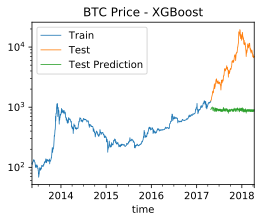

In [37]:
sym = 'BTC'
scale = 'log'
train = sets['trainval']['full'].copy()
train.set_index('time', drop=True, inplace=True)
array = {'Train': train, 'Test': test_result}
plt.figure(figsize=(4, 3))
    
for key in array:
    array[key].query('sym == @sym')['price'].plot(label=key, lw=0.8)
    try:
        array[key].query('sym == @sym')['pred'].plot(label=key+' Prediction', lw=0.8)
    except:
        pass

plt.title('BTC Price - XGBoost')
plt.yscale(scale)
plt.legend()
plt.savefig('BTC Price - XGBoost.png', dpi=200, bbox_inches='tight')
plt.show()

In [38]:
predictor.delete_endpoint()
os.remove(os.path.join(DATA_DIR, 'train.csv'))
os.remove(os.path.join(DATA_DIR, 'val.csv'))

<h2> Neural Network </h2>

In [39]:
W = 7
target = 'roi'

features_dict = create_features(data, W)
features = features_dict['features']
features_df = features_dict['data']
sets = create_sets(data, features, target)

In [40]:
prefix = 'neural-network'

pd.concat([sets['train']['Y'], sets['train']['X']], axis=1).to_csv(os.path.join(DATA_DIR, 'train.csv'), header=False, index=False)
pd.concat([sets['val']['Y'], sets['val']['X']], axis=1).to_csv(os.path.join(DATA_DIR, 'val.csv'), header=False, index=False)

train_location = session.upload_data(os.path.join(DATA_DIR, 'train.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(DATA_DIR, 'val.csv'), key_prefix=prefix)

In [41]:
estimator = SKLearn(entry_point='train.py',
                    source_dir='source',
                    role=role,
                    train_instance_count=1, 
                    train_instance_type='ml.c4.xlarge',
                    framework_version='0.23-1',
                    py_version='py3',
                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                    sagemaker_session=session,
                    hyperparameters={
                        'hidden_layers': 100,
                        'max_iter': 1000,
                        'random_state':100
                    })

estimator.fit({'train': train_location})

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2021-02-06 19:42:42 Starting - Starting the training job...
2021-02-06 19:42:45 Starting - Launching requested ML instances......
2021-02-06 19:43:50 Starting - Preparing the instances for training...
2021-02-06 19:44:37 Downloading - Downloading input data...
2021-02-06 19:45:08 Training - Downloading the training image...
2021-02-06 19:45:23 Training - Training image download completed. Training in progress...2021-02-06 19:45:24,491 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2021-02-06 19:45:24,493 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-02-06 19:45:24,502 sagemaker_sklearn_container.training INFO     Invoking user training script.
2021-02-06 19:45:24,835 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-02-06 19:45:26,287 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-02-06 19:45:26,300 sagemaker-training-toolkit IN

In [42]:
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
predictor.content_type = 'text/csv'
predictor.serializer = csv_serializer

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!

In [43]:
pred_Y = [predictor.predict(batch) for batch in np.array_split(sets['test']['X'].values, 100)]
pred_Y = np.array([float(val) for sublist in pred_Y for val in sublist])

test_result = sets['test']['full'].copy()
test_result['pred'] = pred_Y
test_result = test_result.set_index('time')

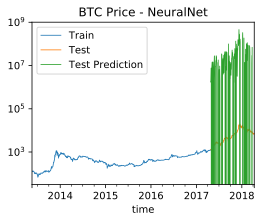

In [44]:
sym = 'BTC'
scale = 'log'
train = sets['trainval']['full'].copy()
train.set_index('time', drop=True, inplace=True)
array = {'Train': train, 'Test': test_result}
plt.figure(figsize=(4, 3))
    
for key in array:
    array[key].query('sym == @sym')['price'].plot(label=key, lw=0.8)
    try:
        array[key].query('sym == @sym')['pred'].plot(label=key+' Prediction', lw=0.8)
    except:
        pass

plt.title('BTC Price - NeuralNet')
plt.yscale(scale)
plt.legend()
plt.savefig('BTC Price - NeuralNet.png', dpi=200, bbox_inches='tight')
plt.show()

In [45]:
predictor.delete_endpoint()
os.remove(os.path.join(DATA_DIR, 'train.csv'))
os.remove(os.path.join(DATA_DIR, 'val.csv'))

<h2> LSTM (DeepAR) </h2>

In [46]:
def write_json_dataset(features_df, features, target, filename): 
    mapping = {}
    symbols = features_df['sym'].unique()
    with open(filename, 'wb') as f:

        for idx, sym in enumerate(symbols):
            
            sym_df = features_df[features_df['sym'] == sym]
            sym_df = sym_df.drop(columns='sym')

            json_obj = {"start": str(sym_df['time'].iloc[0]), 
                        "target": list(sym_df[target]), 
                        "cat":[idx], 
                        "dynamic_feat":[list(sym_df[column]) for column in features]}

            json_line = json.dumps(json_obj) + '\n'
            json_line = json_line.encode('utf-8')

            f.write(json_line)

            mapping[sym] = idx
    
    return mapping
    print('JSON file created at ' + filename)

In [47]:
W = 7
target = 'roi'

features_dict = create_features(data, W)
features = features_dict['features']
features_df = features_dict['data']
sets = create_sets(data, features, target)

In [48]:
mapping = write_json_dataset(sets['trainval']['full'], features, target, 
                             os.path.join(DATA_DIR, 'trainval.json'))

trainval_location = session.upload_data(os.path.join(DATA_DIR, 'trainval.json'), key_prefix=prefix)

In [49]:
context_length = 50

hyperparameters = {
    "epochs": "500",
    "time_freq": 'D',
    "prediction_length": "1",
    "context_length": str(context_length),
    "num_cells": "100",
    "num_layers": "4",
    "mini_batch_size": "128",
    "learning_rate": "0.01",
    "early_stopping_patience": "10"
}

In [50]:
container = get_image_uri(session.boto_region_name,'forecasting-deepar')

estimator = Estimator(container,
                      role=role,   
                      train_instance_count=1, 
                      train_instance_type='ml.m4.xlarge', 
                      output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                      sagemaker_session=session)


estimator.set_hyperparameters(**hyperparameters)

estimator.fit({'train': trainval_location})

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2021-02-06 19:54:04 Starting - Starting the training job...
2021-02-06 19:54:06 Starting - Launching requested ML instances......
2021-02-06 19:55:10 Starting - Preparing the instances for training...
2021-02-06 19:56:03 Downloading - Downloading input data......
2021-02-06 19:57:05 Training - Training image download completed. Training in progress..Arguments: train
[02/06/2021 19:57:08 INFO 140463825921856] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience':

In [ ]:
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


--------

In [ ]:
def json_predictor_input(features_df, date, features, target, mapping, context_length, num_samples=50):
    instances = []
    symbols = features_df['sym'].unique()
    look_back_date = date - pd.Timedelta(context_length, 'D')
    window = features_df.query("time >= @look_back_date & time <= @date")

    for sym in symbols:
        idx = mapping[sym]
        sym_window = window.query("sym == @sym")

        if sym_window.empty:
            continue

        json_obj = {"start": str(list(sym_window['time'])[0]), 
                    "target": list(sym_window[target])[:-1],
                    "cat":[idx], 
                    "dynamic_feat":[list(sym_window[column]) for column in features]}
        instances.append(json_obj)

    configuration = {"num_samples": num_samples, 
                     "output_types": ["mean"]}

    request_data = {"instances": instances, 
                    "configuration": configuration}

    json_request = json.dumps(request_data).encode('utf-8')

    return json_request


def decode_prediction(prediction, encoding='utf-8'):
    '''Accepts a JSON prediction and returns a list of prediction data.
    '''
    prediction_data = json.loads(prediction.decode(encoding))
    prediction_list = []

    for k in range(len(prediction_data['predictions'])):
        prediction_list.append(pd.DataFrame(data=prediction_data['predictions'][k]['mean']))

    return prediction_list


def loop_predict(features_df, start, end, features, target, mapping, context_length):
    dates = list(set(features_df[(features_df.time >= start) & (features_df.time <= end)]['time']))

    df = pd.DataFrame([])
    for date in dates:
        test_features = json_predictor_input(features_df, date, features, target, mapping, context_length)
        json_prediction = predictor.predict(test_features)
        pred = [float(x.values.squeeze()) for x in decode_prediction(json_prediction)]
        temp_df = pd.DataFrame(zip([sym for sym in features_df['sym'].unique()], pred), 
                               columns=['sym', 'pred'])
        temp_df['time'] = date

        df = df.append(temp_df, ignore_index=True)

    return df

In [ ]:
TEST_END = sets['test']['full'].time.max()
pred_Y = loop_predict(features_df, TEST_START, TEST_END, features, target, mapping, context_length)

In [ ]:
test_result = sets['test']['full'].copy()
test_result = pd.merge(test_result, pred_Y, how='left', left_on=['time', 'sym'], right_on=['time', 'sym'])
test_result.set_index('time', drop=True, inplace=True)

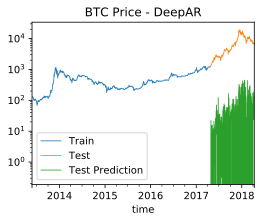

In [59]:
sym = 'BTC'
scale = 'log'
train = sets['trainval']['full'].copy()
train.set_index('time', drop=True, inplace=True)

test_result['pred'] = test_result['pred'] * test_result['price_last']
array = {'Train': train, 'Test': test_result}
plt.figure(figsize=(4, 3))
plt.title('BTC Price - DeepAR')

for key in array:
    array[key].query('sym == @sym')['price'].plot(label=key, lw=0.8)
    try:
        array[key].query('sym == @sym')['pred'].plot(label=key+' Prediction', lw=0.8)
    except:
        pass
plt.yscale(scale)
plt.legend()
plt.savefig('BTC Price - DeepAR.png', dpi=200, bbox_inches='tight')
plt.show()

In [ ]:
predictor.delete_endpoint()
os.remove(os.path.join(DATA_DIR, 'trainval.json'))